In [3]:
import tensorflow as tf
import time
import numpy as np
import os
import copy
import pickle
import argparse
import utility
import pandas as pd
from sklearn.metrics import *

2023-03-28 11:32:31.133344: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 11:32:31.195794: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [20]:
def loadmodel(self, saver, checkpoint_dir):
    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
        saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
        return True
    else:
        return False

In [34]:
reader = tf.train.load_checkpoint('ml1m-6/BPR_check_points')
shape_from_key = reader.get_variable_to_shape_map()
dtype_from_key = reader.get_variable_to_dtype_map()

sorted(shape_from_key.keys())


['BPR/P', 'BPR/Q']

In [35]:
reader.get_tensor('BPR/P')

array([[-0.47717583,  0.13508046, -0.08239254, ...,  0.29737067,
        -0.31184825,  0.31152534],
       [-0.82092255,  0.6933521 , -0.8726745 , ..., -0.23336671,
        -0.76790184, -0.11863742],
       [ 0.2220891 ,  0.400564  , -0.4448207 , ...,  0.6722743 ,
         0.23951352,  0.51433146],
       ...,
       [ 0.04905014,  0.19143747, -0.0490599 , ..., -0.05610065,
        -0.62346107,  0.29387683],
       [-0.4681917 , -0.46256354, -0.58128434, ...,  0.08563785,
        -1.0111028 ,  0.22256766],
       [ 0.6822934 ,  0.7298487 , -0.09003048, ..., -0.00305937,
        -0.67893136, -0.7770701 ]], dtype=float32)

In [36]:
def print_checkpoint(save_path):
    reader = tf.train.load_checkpoint(save_path)
    shapes = reader.get_variable_to_shape_map()
    dtypes = reader.get_variable_to_dtype_map()
    print(f"Checkpoint at '{save_path}':")
    for key in shapes:
        print(f"  (key='{key}', shape={shapes[key]}, dtype={dtypes[key].name}, "
            f"value={reader.get_tensor(key)})")


In [37]:
reader.get_tensor('BPR/Q').shape

(1481, 20)

In [38]:
np.save('Q_tensor.npy', reader.get_tensor('BPR/Q')) # save
np.save('P_tensor.npy', reader.get_tensor('BPR/P')) # save
# new_num_arr = np.load('Q_tensor.npy') # load

In [26]:
print_checkpoint('ml1m-6/BPR_check_points_2')

Checkpoint at 'ml1m-6/BPR_check_points_2':
  (key='BPR/Q', shape=[1481, 20], dtype=float32, value=[[-0.01458513 -0.0278788  -0.02968836 ...  0.01007636  0.01964535
   0.01039099]
 [ 0.02178593 -0.0296652  -0.00069894 ... -0.02580264  0.00797478
  -0.03780304]
 [ 0.01837691 -0.03319061 -0.01558379 ... -0.02123228  0.00159044
  -0.02819812]
 ...
 [ 0.00656306 -0.00753659  0.00897468 ... -0.00777141 -0.02740526
  -0.03508031]
 [-0.00663131 -0.00444541 -0.00344932 ...  0.00363906  0.00850748
  -0.00016008]
 [-0.0069091  -0.01007038 -0.00190771 ...  0.00596577  0.01874839
   0.00922376]])
  (key='BPR/P', shape=[6036, 20], dtype=float32, value=[[ 1.43514667e-03 -3.01657477e-03 -1.71056297e-03 ... -1.28840026e-03
   2.55405903e-03 -3.80083174e-03]
 [-4.36936622e-04  2.04426404e-02  1.68757234e-02 ...  2.37677014e-03
   3.48560698e-03  2.24851351e-03]
 [-1.61453262e-02  5.16602723e-03 -4.78330208e-03 ...  1.67072657e-02
   1.58163588e-02  1.61972940e-02]
 ...
 [-7.28358600e-07  1.48044619e-05 

In [39]:
Rec = np.matmul(reader.get_tensor('BPR/P'), reader.get_tensor('BPR/Q').T)

In [40]:
Rec

array([[ 3.777458 ,  4.221402 ,  5.198299 , ..., -4.2804947, -2.578201 ,
        -2.816697 ],
       [-0.811322 ,  1.6305199,  1.3584685, ..., -1.1151903, -3.3449132,
        -4.613763 ],
       [ 2.7363856,  1.0603654,  5.1922445, ..., -3.727843 , -3.6910203,
        -3.445971 ],
       ...,
       [ 0.3022063,  2.698015 ,  1.7298616, ..., -1.4951588, -1.1846492,
        -1.3607007],
       [ 3.5729375,  6.708638 ,  4.714961 , ..., -4.493719 , -2.7313833,
        -2.9217112],
       [ 1.204689 ,  2.7632651,  1.7827291, ..., -3.1170988, -1.994886 ,
        -3.3972826]], dtype=float32)

In [41]:
train_df = pd.read_pickle(r'ml1m-6/training_df.pkl')
vali_df = pd.read_pickle(r'ml1m-6/testing_df.pkl')   # for validation
# vali_df = pickle.load(open('./' + dataname + '/testing_df.pkl'))  # for testing
key_genre = pd.read_pickle(r'ml1m-6/key_genre.pkl')
item_idd_genre_list = pd.read_pickle(r'ml1m-6/item_idd_genre_list.pkl')
genre_item_vector = pd.read_pickle(r'ml1m-6/genre_item_vector.pkl')
genre_count = pd.read_pickle(r'ml1m-6/genre_count.pkl')
user_genre_count = pd.read_pickle(r'ml1m-6/user_genre_count.pkl')

num_item = len(train_df['item_id'].unique())
num_user = len(train_df['user_id'].unique())
num_genre = len(key_genre)


In [42]:
item_genre_list = []
for u in range(num_item):
    gl = item_idd_genre_list[u]
    tmp = []
    for g in gl:
        if g in key_genre:
            tmp.append(g)
    item_genre_list.append(tmp)

In [43]:
utility.ranking_analysis(Rec, vali_df, train_df, key_genre, item_genre_list,
                                                      user_genre_count)


####################################################################################################
# System-level Recall:
# 			Recall@1	Recall@5	Recall@10	Recall@15
# Sci-Fi		0.02311		0.09894		0.17535		0.23561
# Horror		0.01374		0.05641		0.10064		0.13990
# Crime		0.01818		0.08024		0.13867		0.19032
# Adventure		0.02120		0.09090		0.15931		0.21637
# Children's		0.01420		0.05737		0.10250		0.14651
# Romance		0.01402		0.06079		0.11284		0.15781
# relative std		0.21325		0.22761		0.21699		0.19829
####################################################################################################
# User-level Recall:
# 			Recall@1	Recall@5	Recall@10	Recall@15
# Sci-Fi		0.03001		0.11798		0.20318		0.26870
# Horror		0.01442		0.05783		0.10390		0.15012
# Crime		0.01913		0.08711		0.14762		0.20453
# Adventure		0.02851		0.11374		0.18733		0.24986
# Children's		0.01513		0.05909		0.10926		0.15490
# Romance		0.01881		0.07423		0.13453		0.18373
# relative std		0.29072		0.28184		0.25068		0.22132
###########

(array([0.47163318, 0.46831565, 0.45548423, 0.4395613 ]),
 array([0.2132465 , 0.22760523, 0.21698537, 0.19828977]))

In [44]:
Q_tensor = (np.load('Q_tensor.npy'))
P_tensor = (np.load('P_tensor.npy'))
Rec = np.matmul(P_tensor, Q_tensor.T)

In [45]:
utility.ranking_analysis(Rec, vali_df, train_df, key_genre, item_genre_list,
                                                      user_genre_count)


####################################################################################################
# System-level Recall:
# 			Recall@1	Recall@5	Recall@10	Recall@15
# Sci-Fi		0.02311		0.09894		0.17535		0.23561
# Horror		0.01374		0.05641		0.10064		0.13990
# Crime		0.01818		0.08024		0.13867		0.19032
# Adventure		0.02120		0.09090		0.15931		0.21637
# Children's		0.01420		0.05737		0.10250		0.14651
# Romance		0.01402		0.06079		0.11284		0.15781
# relative std		0.21325		0.22761		0.21699		0.19829
####################################################################################################
# User-level Recall:
# 			Recall@1	Recall@5	Recall@10	Recall@15
# Sci-Fi		0.03001		0.11798		0.20318		0.26870
# Horror		0.01442		0.05783		0.10390		0.15012
# Crime		0.01913		0.08711		0.14762		0.20453
# Adventure		0.02851		0.11374		0.18733		0.24986
# Children's		0.01513		0.05909		0.10926		0.15490
# Romance		0.01881		0.07423		0.13453		0.18373
# relative std		0.29072		0.28184		0.25068		0.22132
###########

(array([0.47163318, 0.46831565, 0.45548423, 0.4395613 ]),
 array([0.2132465 , 0.22760523, 0.21698537, 0.19828977]))

In [54]:
utility.test_model_all(Rec, vali_df, train_df)

precision_1	[0.1598434],	||	 precision_5	[0.1363475],	||	 precision_10	[0.1221787],	||	 precision_15	[0.1118548]
recall_1   	[0.0272944],	||	 recall_5   	[0.1075401],	||	 recall_10   	[0.1816718],	||	 recall_15   	[0.2408833]
f_measure_1	[0.0466270],	||	 f_measure_5	[0.1202425],	||	 f_measure_10	[0.1461010],	||	 f_measure_15	[0.1527703]
ndcg_1     	[0.1598434],	||	 ndcg_5     	[0.1607376],	||	 ndcg_10     	[0.1780276],	||	 ndcg_15     	[0.1951911]


(array([0.15984336, 0.13634745, 0.12217871, 0.11185475]),
 array([0.02729443, 0.10754011, 0.1816718 , 0.2408833 ]),
 [0.04662695945850442,
  0.12024246082827848,
  0.14610096393529334,
  0.15277025982451498],
 array([0.15984336, 0.16073764, 0.1780276 , 0.19519114]))

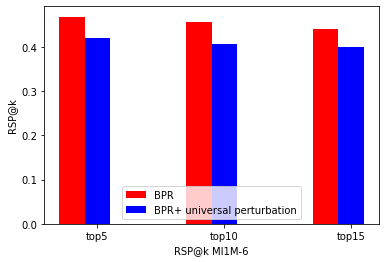

In [59]:


# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data
x = np.arange(3)
y1 = [0.46831565, 0.45548423, 0.4395613]
y2 = [0.16213229, 0.17570175, 0.19103656]
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='red')
plt.bar(x, y2, width, color='blue')
plt.xticks(x, ["top5", "top10", "top15"])
plt.ylabel("RSP@k")
plt.xlabel("RSP@k Ml1M-6")
plt.legend(["BPR", "BPR+ universal perturbation"])
plt.show()

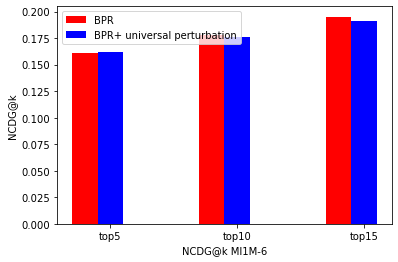

In [60]:


# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data
x = np.arange(3)
y1 = [0.16073764, 0.1780276 , 0.19519114]
y2 = [0.16213229, 0.17570175, 0.19103656]
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='red')
plt.bar(x, y2, width, color='blue')
plt.xticks(x, ["top5", "top10", "top15"])
plt.ylabel("NCDG@k")
plt.xlabel("NCDG@k Ml1M-6")
plt.legend(["BPR", "BPR+ universal perturbation"])
plt.show()